# Building Histograms

### How to run this notebook:
* Give date and type of vehicle as arguments
* If simplified etapas file does not exist, then run RunDailyEtapasBuilder.runSimplifyEtapas(). If it already exists, then omit it

Run the builder in this order:
1. etapas_df = RunDailyEtapasBuilder.loadSimplifiedEtapas()
2. merged_df = RunDailyEtapasBuilder.includeTorniquetesDate(etapas_df)
3. clean_df = RunDailyEtapasBuilder.cleanDataFrame(merged_df)
4. sorted_df = RunDailyEtapasBuilder.sortDataFrame(clean_df)

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

In [3]:
import RunDailyEtapasBuilder

Enter the date to analyze: 2017-03-01
Enter the vehicle to analyze: BUS
Consider ZP in perfiles file (0/1)?: 0


* Running the builder of the dataframe

In [4]:
etapas_df  =RunDailyEtapasBuilder.loadSimplifiedEtapas()
merged_df = RunDailyEtapasBuilder.mergeTurnstileData(etapas_df)
clean_df = RunDailyEtapasBuilder.cleanDataFrame(merged_df)
sorted_df = RunDailyEtapasBuilder.sortDataFrame(clean_df)

Not found in turnstile database: 1614656


* Counting.

In [5]:
print(etapas_df['id'].count())
print(merged_df['id'].count())
print(clean_df['id'].count())
print(sorted_df['id'].count())

2329229
2329229
2210399
2210399


* Adding necessary attributes

In [6]:
sorted_df['mismo_paradero'] = (sorted_df['par_subida']==sorted_df['par_subida'].shift()).fillna(False)
sorted_df['misma_patente'] = (sorted_df['sitio_subida']==sorted_df['sitio_subida'].shift()).fillna(False)
sorted_df.loc[(sorted_df.mismo_paradero == True) & (sorted_df.misma_patente == True), 'diferencia_tiempo'] = (sorted_df['t_subida']-sorted_df['t_subida'].shift())
sorted_df.loc[(sorted_df.mismo_paradero == True) & (sorted_df.misma_patente == False), 'diferencia_tiempo'] = pd.NaT
sorted_df['fecha_instalacion'] = pd.to_datetime(sorted_df.fecha_instalacion)
sorted_df['diferencia_tiempo_secs'] = sorted_df['diferencia_tiempo'].dt.total_seconds()
sorted_df['si_torniquete'] = (sorted_df['fecha_instalacion']<=sorted_df['t_subida'])

* Filtering by mismo_paradero, misma_patente and by si_torniquete

In [7]:
filtered_df = sorted_df[(sorted_df.mismo_paradero==True) & (sorted_df.misma_patente==True)]
filtered_turnstile_df = filtered_df[filtered_df['si_torniquete']==True]
filtered_no_turnstile_df = filtered_df[filtered_df['si_torniquete']==False]

* Counting and checking

In [8]:
print(filtered_df['id'].count())
print(filtered_turnstile_df['id'].count())
print(filtered_no_turnstile_df['id'].count())
checking = filtered_turnstile_df['id'].count() + filtered_no_turnstile_df['id'].count()
print(checking)

1380689
285058
1095631
1380689


* Getting rid of unecessary dataframes

In [9]:
del etapas_df
del merged_df
del clean_df

* TODO: Currently, there are rows with extremely high values for the 'diferencia_tiempo' attribute (e.g. >=25 mins). This should be fixed considering the idExpedicion attribute present in the corresponding 'perfiles' database. The following graphs and descriptive statistics consider only the 95th percentile for the 'diferencia_tiempo_secs' attribute. 

##### Descriptive statistics: all-database (Omitted)

In [ ]:
filtered_df.describe()

##### Descriptive statistics and plotting: WITH-TURNSTILE DATABASE

In [10]:
filtered_turnstile_df.describe()

,id,nviaje,diferencia_tiempo,diferencia_tiempo_secs
count,2.850580e+05,285058.000000,285058,285058.000000
mean,2.241798e+09,1.575978,0 days 00:00:09.368040,9.368041
std,1.298954e+09,0.840912,0 days 00:01:26.548090,86.548090
min,1.163146e+06,1.000000,0 days 00:00:00,0.000000
25%,9.351316e+08,1.000000,0 days 00:00:03,3.000000
50%,2.512592e+09,1.000000,0 days 00:00:05,5.000000
75%,3.381195e+09,2.000000,0 days 00:00:07,7.000000
max,4.293306e+09,14.000000,0 days 11:20:33,40833.000000


In [31]:
with_turnstile_95 = filtered_turnstile_df.diferencia_tiempo.quantile(0.95)
print ('Percentile 95th for turnstile database is: ' + str(with_turnstile_95))

Percentile 95th for turnstile database is: 0 days 00:00:27


##### Descriptive statistics and plotting: WITHOUT-TURNSTILE DATABASE

In [32]:
filtered_no_turnstile_df.describe()

,id,nviaje,diferencia_tiempo,diferencia_tiempo_secs
count,1.095631e+06,1.095631e+06,1095631,1.095631e+06
mean,2.251215e+09,1.631636e+00,0 days 00:00:07.090680,7.090680e+00
std,1.294543e+09,8.589820e-01,0 days 00:01:19.468331,7.946833e+01
min,5.454520e+05,1.000000e+00,0 days 00:00:00,0.000000e+00
25%,9.356420e+08,1.000000e+00,0 days 00:00:02,2.000000e+00
50%,2.512512e+09,1.000000e+00,0 days 00:00:03,3.000000e+00
75%,3.417347e+09,2.000000e+00,0 days 00:00:04,4.000000e+00
max,4.293302e+09,1.900000e+01,0 days 09:33:53,3.443300e+04


In [33]:
without_turnstile_95 = filtered_no_turnstile_df.diferencia_tiempo.quantile(0.95)
print('Percentile 95th for without_turnstile database is: ' + str(without_turnstile_95))

Percentile 95th for without_turnstile database is: 0 days 00:00:23


### Filtering by diferencia_tiempo<=95th percentile in the corresponding databases. BE AWARE.

In [34]:
with_turnstile_95_df = filtered_turnstile_df[filtered_turnstile_df['diferencia_tiempo']<=with_turnstile_95]

In [35]:
without_turnstile_95_df = filtered_no_turnstile_df[filtered_no_turnstile_df['diferencia_tiempo']<=without_turnstile_95]

In [36]:
with_turnstile_95_df.describe()

,id,nviaje,diferencia_tiempo,diferencia_tiempo_secs
count,2.708190e+05,270819.000000,270819,270819.000000
mean,2.241755e+09,1.582186,0 days 00:00:05.709496,5.709496
std,1.299027e+09,0.844905,0 days 00:00:04.169270,4.169270
min,1.163146e+06,1.000000,0 days 00:00:00,0.000000
25%,9.350776e+08,1.000000,0 days 00:00:03,3.000000
50%,2.512587e+09,1.000000,0 days 00:00:04,4.000000
75%,3.380940e+09,2.000000,0 days 00:00:06,6.000000
max,4.293306e+09,14.000000,0 days 00:00:27,27.000000


In [37]:
without_turnstile_95_df.describe()

,id,nviaje,diferencia_tiempo,diferencia_tiempo_secs
count,1.041624e+06,1.041624e+06,1041624,1.041624e+06
mean,2.252309e+09,1.638864e+00,0 days 00:00:03.365189,3.365189e+00
std,1.294399e+09,8.622452e-01,0 days 00:00:03.332207,3.332208e+00
min,5.454520e+05,1.000000e+00,0 days 00:00:00,0.000000e+00
25%,9.357000e+08,1.000000e+00,0 days 00:00:02,2.000000e+00
50%,2.512588e+09,1.000000e+00,0 days 00:00:03,3.000000e+00
75%,3.418037e+09,2.000000e+00,0 days 00:00:04,4.000000e+00
max,4.293302e+09,1.900000e+01,0 days 00:00:23,2.300000e+01


* Plotting

In [53]:
colors = [(244, 67, 54),(3, 169, 244),(205, 220, 57)]
for i in range(len(colors)):
    r, g, b = colors[i]  
    colors[i] = (r / 255., g / 255., b / 255.)

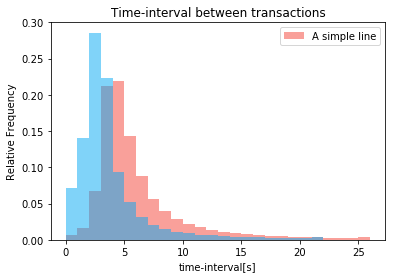

In [70]:
with_turnstile_95_df_hist, ax_1 = plt.subplots()
with_turnstile_95_df_hist_data = ax_1.hist(with_turnstile_95_df['diferencia_tiempo_secs'].values, weights=np.zeros_like(with_turnstile_95_df['diferencia_tiempo_secs'].values) + 1. / with_turnstile_95_df['diferencia_tiempo_secs'].values.size,bins=range(0,int(with_turnstile_95.total_seconds()),1),color=colors[0], alpha=0.5, label='Inline label')
ax_1.set_title('Time-interval between transactions')
ax_1.set_xlabel('time-interval[s]')
ax_1.set_ylabel('Relative Frequency')
ax_1.legend(['A simple line'])
without_turnstile_95_df_hist_data = ax_1.hist(without_turnstile_95_df['diferencia_tiempo_secs'].values, weights=np.zeros_like(without_turnstile_95_df['diferencia_tiempo_secs'].values) + 1. / without_turnstile_95_df['diferencia_tiempo_secs'].values.size,bins=range(0,int(without_turnstile_95.total_seconds()),1),color=colors[1], alpha = 0.5)